### 1. Data Acquisition and Preprocessing

In [82]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv('./dataset/telecom_customer_churn.csv')

# Display the first few rows of the dataset
print(data.head())


  Customer ID  Gender  Age Married  Number of Dependents          City   
0  0002-ORFBO  Female   37     Yes                     0  Frazier Park  \
1  0003-MKNFE    Male   46      No                     0      Glendale   
2  0004-TLHLJ    Male   50      No                     0    Costa Mesa   
3  0011-IGKFF    Male   78     Yes                     0      Martinez   
4  0013-EXCHZ  Female   75     Yes                     0     Camarillo   

   Zip Code   Latitude   Longitude  Number of Referrals  ...   Payment Method   
0     93225  34.827662 -118.999073                    2  ...      Credit Card  \
1     91206  34.162515 -118.203869                    0  ...      Credit Card   
2     92627  33.645672 -117.922613                    0  ...  Bank Withdrawal   
3     94553  38.014457 -122.115432                    1  ...  Bank Withdrawal   
4     93010  34.227846 -119.079903                    3  ...      Credit Card   

  Monthly Charge Total Charges  Total Refunds Total Extra Data Charg

In [139]:
# Select relevant features
selected_features = [
    'Gender', 'Age', 'Married', 'Number of Dependents', 'Zip Code',
    'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service', 
    'Avg Monthly Long Distance Charges', 'Multiple Lines', 'Internet Service',
    'Internet Type', 'Avg Monthly GB Download', 'Online Security', 'Online Backup',
    'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
    'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method',
    'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 
    'Total Long Distance Charges', 'Total Revenue'
]

In [140]:
# Rename columns in the DataFrame
def rename_columns(df):
    new_column_names = {col: col.replace(' ', '_') for col in df.columns}
    df.rename(columns=new_column_names, inplace=True)
    return df

data = rename_columns(data)

# Check if selected features are in the DataFrame
selected_features = [feature.replace(' ', '_') for feature in selected_features]
missing_features = [feature for feature in selected_features_renamed if feature not in data.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    print("All selected features are present in the DataFrame.")

All selected features are present in the DataFrame.


### 2. Feature Engineering

In [141]:
# Feature Engineering
data['CLTV'] = data['Total_Revenue'] - data['Total_Refunds']
data['ARPU'] = data['Total_Revenue'] / data['Tenure_in_Months']
data['LongDistanceChargeRatio'] = data['Avg_Monthly_Long_Distance_Charges'] / data['Monthly_Charge']

# Adding new features to the selected features list
selected_features.extend(['CLTV', 'ARPU', 'LongDistanceChargeRatio'])

#### Preprocessing Cont....

In [143]:
# Split data into features and target
X = data[selected_features]
y = data['Customer_Status']
# Merge 'Stayed' and 'Joined' into a single 'Stayed' class
y = data['Customer_Status'].replace({'Joined': 'Stayed'})

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# OneHotEncoder setup
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Identify numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# StandardScaler setup
scaler = StandardScaler()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', imputer),
            ('scaler', scaler)
        ]), numerical_columns),
        ('cat', Pipeline(steps=[
            ('imputer', imputer),
            ('encoder', encoder)
        ]), categorical_columns)
    ]
)

In [144]:
# Apply the preprocessing pipeline
X_preprocessed = preprocessor.fit_transform(X)

# Extract feature names after transformation
encoded_cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_columns)

processed_columns = numerical_columns + list(encoded_cat_columns)

print(X_preprocessed.shape)

# Convert the processed data back to a DataFrame for ease of handling
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=processed_columns)

# Display the preprocessed data
print(X_preprocessed_df.head(10))

(7043, 40)
        Age  Number_of_Dependents  Zip_Code  Number_of_Referrals   
0 -0.567773             -0.486835 -0.140615             0.016039  \
1 -0.030433             -0.486835 -1.228066            -0.650409   
2  0.208385             -0.486835 -0.462703            -0.650409   
3  1.880110             -0.486835  0.574657            -0.317185   
4  1.700997             -0.486835 -0.256416             0.349263   
5 -1.403636              2.629292  1.001235            -0.650409   
6  1.223361             -0.486835 -0.026430            -0.317185   
7  0.327794             -0.486835  0.577350             2.015382   
8  1.283066             -0.486835 -0.227869            -0.650409   
9 -0.209546              0.551874  1.182208             0.349263   

   Tenure_in_Months  Avg_Monthly_Long_Distance_Charges   
0         -0.952994                           1.293091  \
1         -0.952994                          -1.027653   
2         -1.156740                           0.653239   
3       

In [145]:
# Split the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed_df, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

# Save the preprocessed data to csv files
X_train.to_csv('dataset/training/X_train.csv', index=False)
X_val.to_csv('dataset/training/X_val.csv', index=False)
X_test.to_csv('dataset/training/X_test.csv', index=False)
y_train.to_csv('dataset/training/y_train.csv', index=False)
y_val.to_csv('dataset/training/y_val.csv', index=False)
y_test.to_csv('dataset/training/y_test.csv', index=False)

(4930, 40)
(1408, 40)
(705, 40)


#### Save Preprocessing Pipeline

In [146]:
import joblib

# Save the preprocessing pipeline
joblib.dump(preprocessor, 'preprocessor_pipeline.joblib')

['preprocessor_pipeline.joblib']

### 3. Model Selection

In [148]:
import pandas as pd
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap

# Load preprocessed data
X_train = pd.read_csv('dataset/training/X_train.csv')
X_val = pd.read_csv('dataset/training/X_val.csv')
X_test = pd.read_csv('dataset/training/X_test.csv')
y_train = pd.read_csv('dataset/training/y_train.csv').squeeze()
y_val = pd.read_csv('dataset/training/y_val.csv').squeeze()
y_test = pd.read_csv('dataset/training/y_test.csv').squeeze()

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Save the label encoder for future use
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [118]:
# Defining models and their hyperparameters for grid search
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10]
    }
}

In [119]:
# Check for unseen categories in categorical features
for column in X_train.select_dtypes(include=['object']).columns:
    train_categories = set(X_train[column].unique())
    val_categories = set(X_val[column].unique())
    unseen_categories = val_categories - train_categories
    if unseen_categories:
        print(f"Unseen categories in {column}: {unseen_categories}")

### Model Training

In [120]:
best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train_encoded)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

# Save the best models
for model_name, model in best_models.items():
    joblib.dump(model, f'models/best_{model_name.replace(" ", "_").lower()}.joblib')

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 10}
Training Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


### 4. Model Evaluation

In [122]:
# Load the best models
best_logistic_regression = joblib.load('models/best_logistic_regression.joblib')
best_random_forest = joblib.load('models/best_random_forest.joblib')
best_xgboost = joblib.load('models/best_xgboost.joblib')

# Function to evaluate a model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    return accuracy, precision, recall, f1, auc_roc

# Evaluate the models
metrics = {}
for model_name, model in best_models.items():
    metrics[model_name] = evaluate_model(model, X_test, y_test_encoded)

# Print the evaluation metrics
for model_name, (accuracy, precision, recall, f1, auc_roc) in metrics.items():
    print(f"{model_name}:\n"
          f"Accuracy: {accuracy:.4f}\n"
          f"Precision: {precision:.4f}\n"
          f"Recall: {recall:.4f}\n"
          f"F1-score: {f1:.4f}\n"
          f"AUC-ROC: {auc_roc:.4f}\n")

Logistic Regression:
Accuracy: 0.8255
Precision: 0.8808
Recall: 0.8825
F1-score: 0.8816
AUC-ROC: 0.8805

Random Forest:
Accuracy: 0.8340
Precision: 0.8628
Recall: 0.9210
F1-score: 0.8910
AUC-ROC: 0.8716

XGBoost:
Accuracy: 0.8383
Precision: 0.8785
Recall: 0.9056
F1-score: 0.8918
AUC-ROC: 0.8919



### SHAP Analysis on the best model (xgboost)

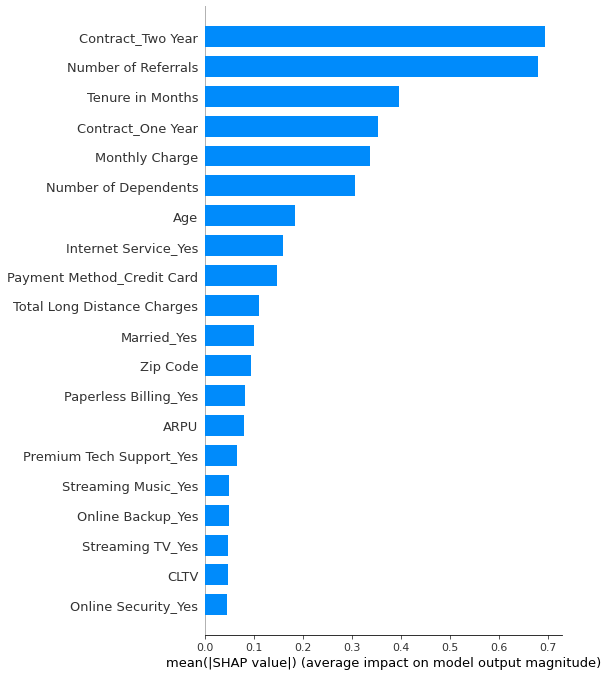

In [125]:
# Summary plot
'''
The summary plot shows the distribution of SHAP values for each feature, 
giving a sense of which features are most impactful and how they are distributed.
'''
explainer = shap.TreeExplainer(best_xgboost)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

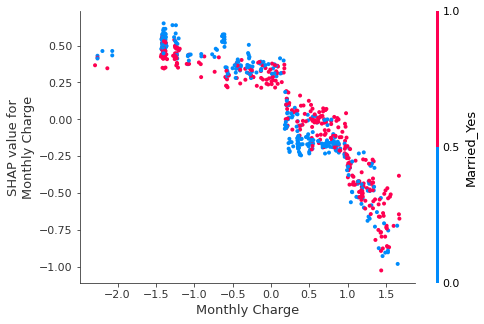

In [126]:
# Dependence plot
'''
The dependence plot shows the relationship between a feature's value and its impact on the model's output, 
revealing any interaction effects with other features.
'''
shap.dependence_plot('Monthly Charge', shap_values, X_test)

In [129]:
# Force plot for a single prediction
'''
The force plot shows the impact of each feature on a single prediction, 
providing a detailed view of how the model arrives at a particular prediction.
'''
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

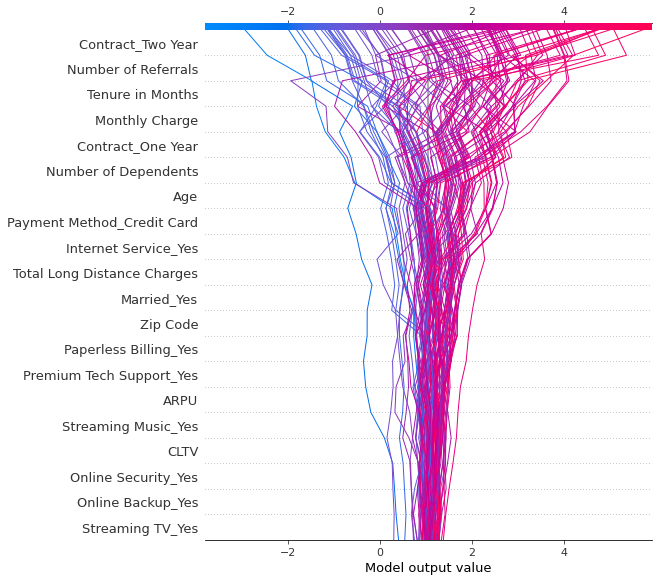

In [130]:
# Decision plot
'''
The decision plot provides a high-level view of how the model makes decisions for different subsets of the data, 
showing the cumulative effect of each feature.
'''
shap.decision_plot(explainer.expected_value, shap_values[:100], X_test.iloc[:100])

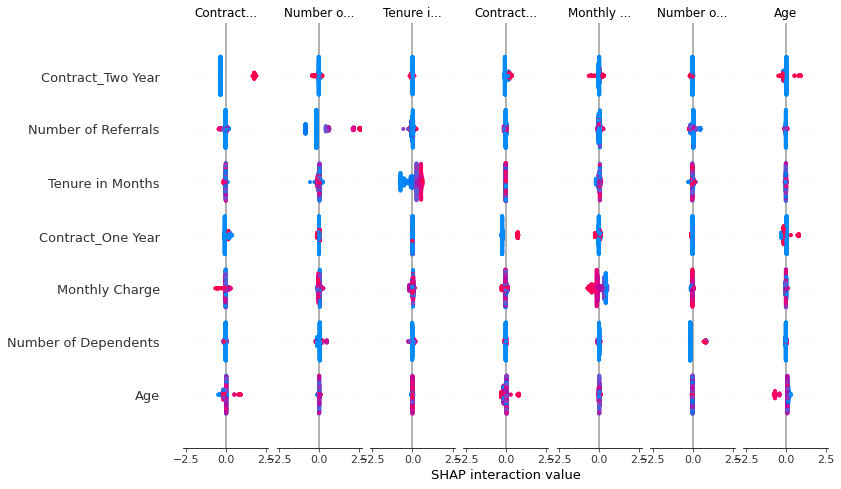

In [131]:
# Interaction values
'''
Interaction values help identify how pairs of features interact and jointly contribute to the prediction. 
This can be particularly useful to understand complex relationships in the data.
'''
shap_interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_interaction_values, X_test)

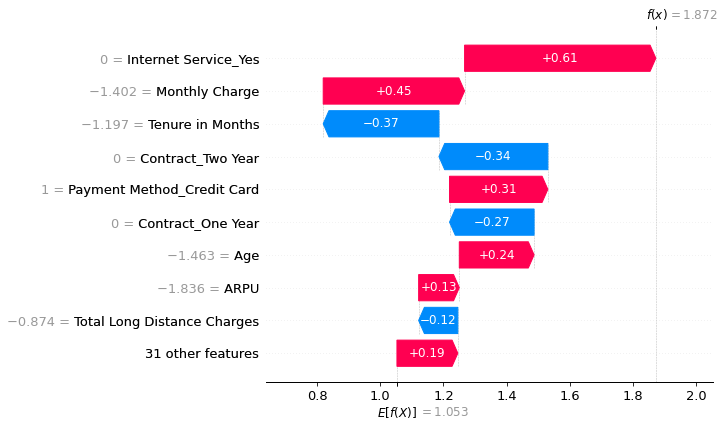

In [132]:
# Waterfall plot for a single prediction
'''
The waterfall plot provides a detailed view of the contributions of each feature to a single prediction, 
similar to the force plot but in a different format.
'''
shap.waterfall_plot(shap.Explanation(values=shap_values[0,:], 
                                     base_values=explainer.expected_value, 
                                     data=X_test.iloc[0,:]))